In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism() 

In [23]:
# Load the Dataset 
df = pd.read_csv('./data_with_indicators/crypto_prices_1m_with_indicators.csv', parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Number of Trades,Coin,EMA9,EMA21,...,STOCHS_Sell,+DI,-DI,ADX,ADX_Buy,ADX_Sell,Aroon_Up,Aroon_Down,Aroon_Buy,Aroon_Sell
0,2025-01-01 00:00:00,93576.00,93610.93,93537.50,93610.93,8.21827,2631,BTC,93610.930000,93610.930000,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
1,2025-01-01 00:01:00,93610.93,93652.00,93606.20,93652.00,12.14029,1273,BTC,93619.144000,93614.663636,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
2,2025-01-01 00:02:00,93652.00,93702.15,93635.98,93702.15,11.60597,1095,BTC,93635.745200,93622.616942,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
3,2025-01-01 00:03:00,93702.14,93702.15,93654.48,93677.98,8.72958,1461,BTC,93644.192160,93627.649947,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
4,2025-01-01 00:04:00,93677.98,93677.99,93659.92,93661.20,5.24749,988,BTC,93647.593728,93630.699952,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False


In [4]:
# Faceted EDA with enhanced styling
crypto = ['BTC', 'ETH', 'SOL', 'XRP']
colors = ['tab:purple', 'tab:green', 'tab:red', 'tab:blue']

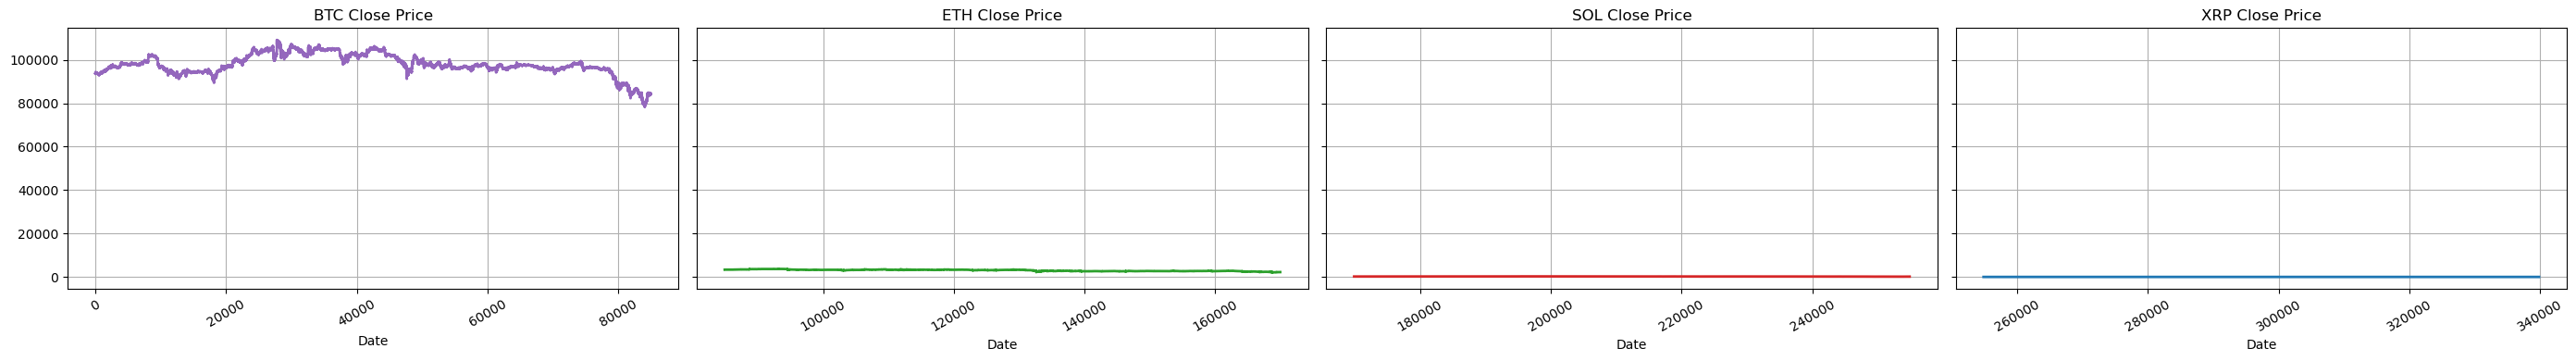

In [5]:
# Close Price Trends Facet 
fig, axes = plt.subplots(1, len(crypto), figsize=(28, 4), sharey=True)
for ax, ticker, color in zip(axes, crypto, colors):
    df_ticker = df[df['Coin'] == ticker]
    ax.plot(df_ticker.index, df_ticker['Close'], color=color, linewidth=2)
    ax.set_title(f'{ticker} Close Price')
    ax.set_xlabel('Date')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
    ax.grid(True)
plt.tight_layout()
plt.show()

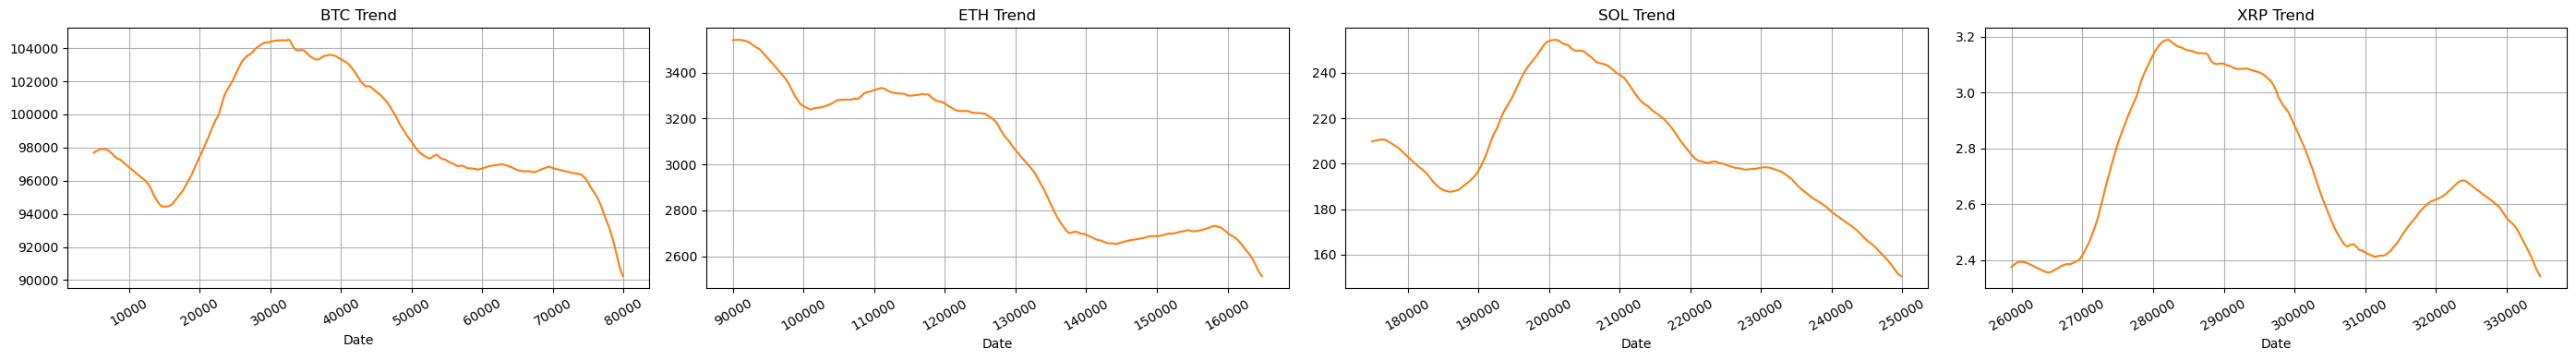

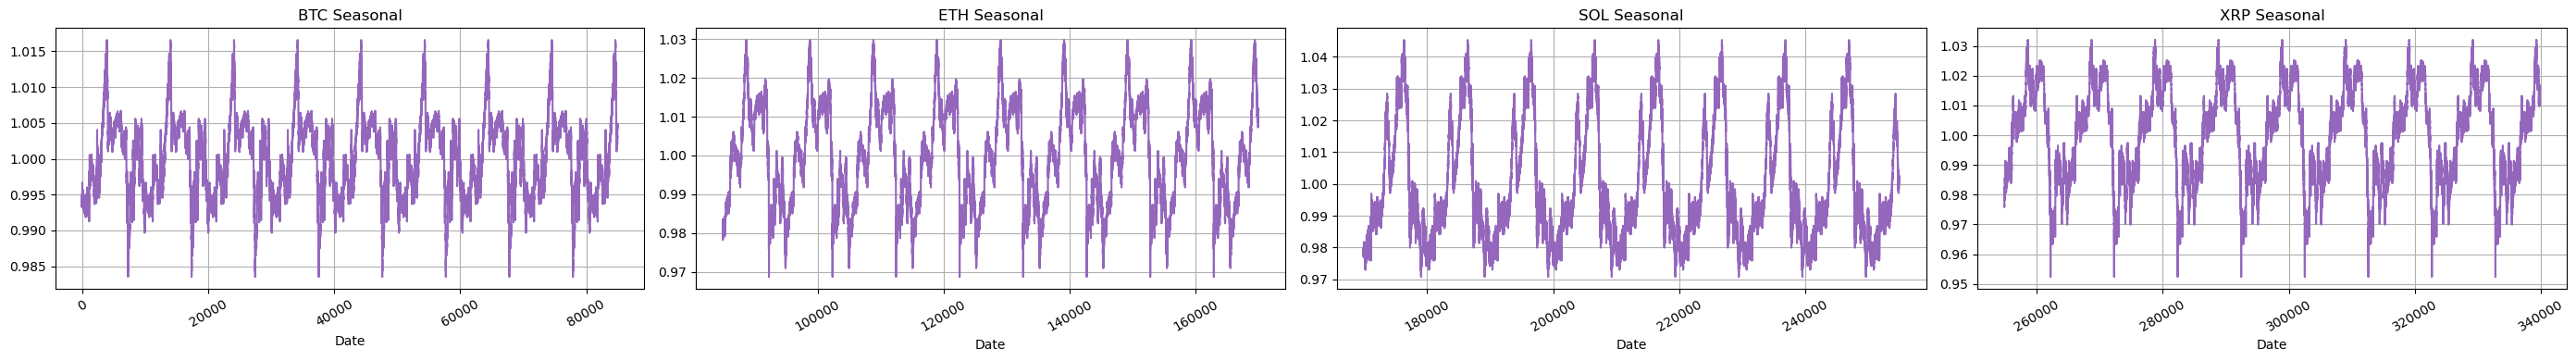

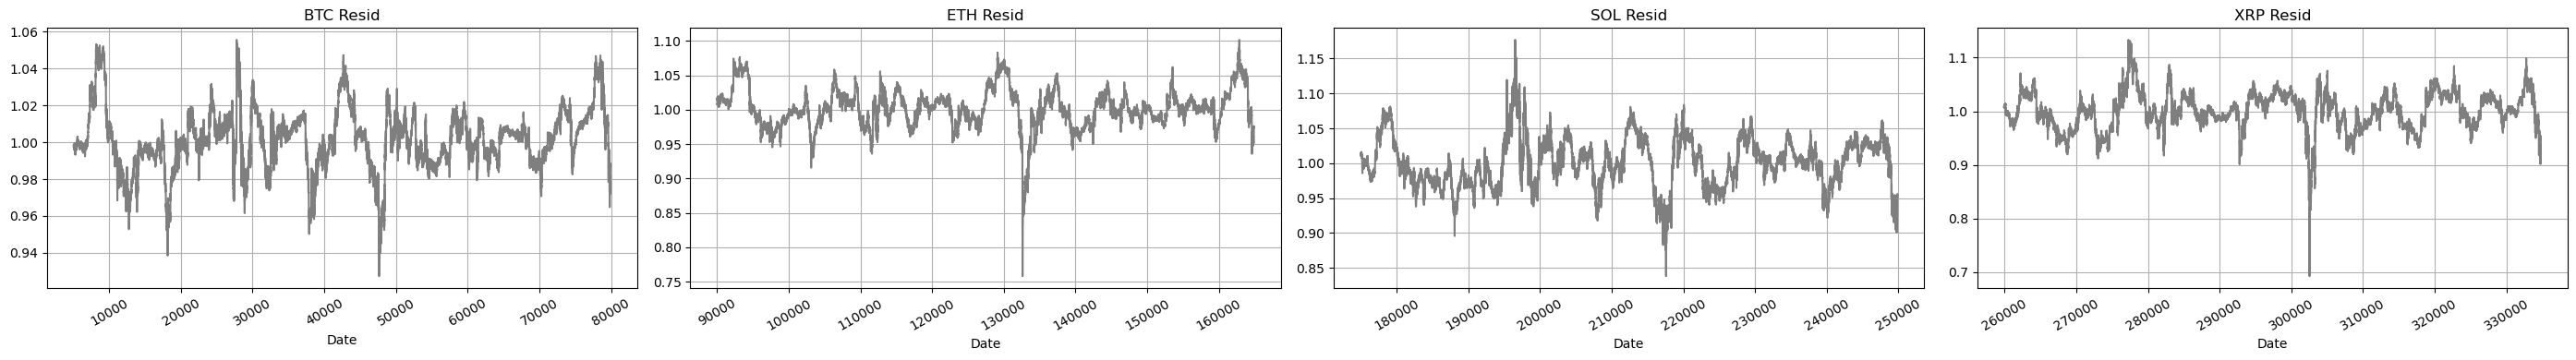

In [6]:
# Seasonal Decomposition Facet 
component_colors = {'trend': 'tab:orange', 'seasonal': 'tab:purple', 'resid': 'tab:gray'}
for comp, comp_color in component_colors.items():
    fig, axes = plt.subplots(1, len(crypto), figsize=(28, 4))
    for ax, ticker, color in zip(axes, crypto, colors):
        df_ticker = df[df['Coin'] == ticker]
        # crypto prices fluctuate proportionally with price levels, therefore multiplicative model is used
        result = seasonal_decompose(df_ticker['Close'], model='multiplicative', period=10080) # 10080 minutes in a week
        comp_series = getattr(result, comp)
        ax.plot(comp_series.index, comp_series, color=comp_color)
        ax.set_title(f'{ticker} {comp.capitalize()}')
        ax.set_xlabel('Date')
        for label in ax.get_xticklabels():
            label.set_rotation(30)
        ax.grid(True)
    plt.tight_layout()
    plt.show()

# Analysis 
# Trend: Overall downward movements 
# Seasonal: Repeating patterns are visible - weekly seasonality
# Residual: Relatively stable noise, but some large spikes are visible (might be market shocks)

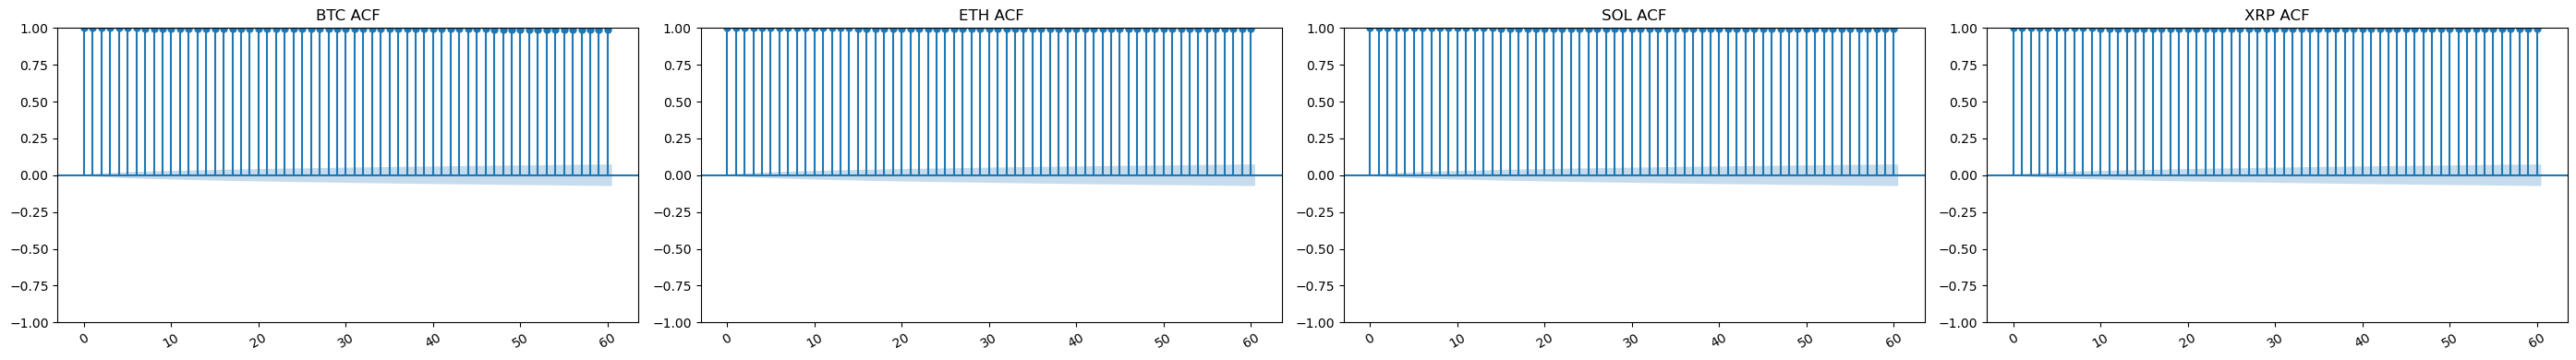

In [7]:
# Standard ACF Facet
fig, axes = plt.subplots(1, len(crypto), figsize=(28, 4))
for ax, ticker in zip(axes, crypto):
    df_ticker = df[df['Coin'] == ticker]
    plot_acf(df_ticker['Close'].dropna(), lags=60, ax=ax)
    ax.set_title(f'{ticker} ACF')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
plt.tight_layout()
plt.show()

# High Autocorrelation: Plots show very high and persistent autocorrelations. All the bars are at the maximum value of 1, indicating a strong positive correlation at every lag.
# No Decay: There is no visible decay in the autocorrelation as the lag increases. This suggests that past values of prices are highly predictive of future values for a very long period.
# Stationarity: This pattern is indicative of a non-stationary time series. A stationary time series would typically show the autocorrelation decreasing as the lag increases, eventually falling within the confidence interval.
# When modeling prices, it's important to account for the non-stationarity.

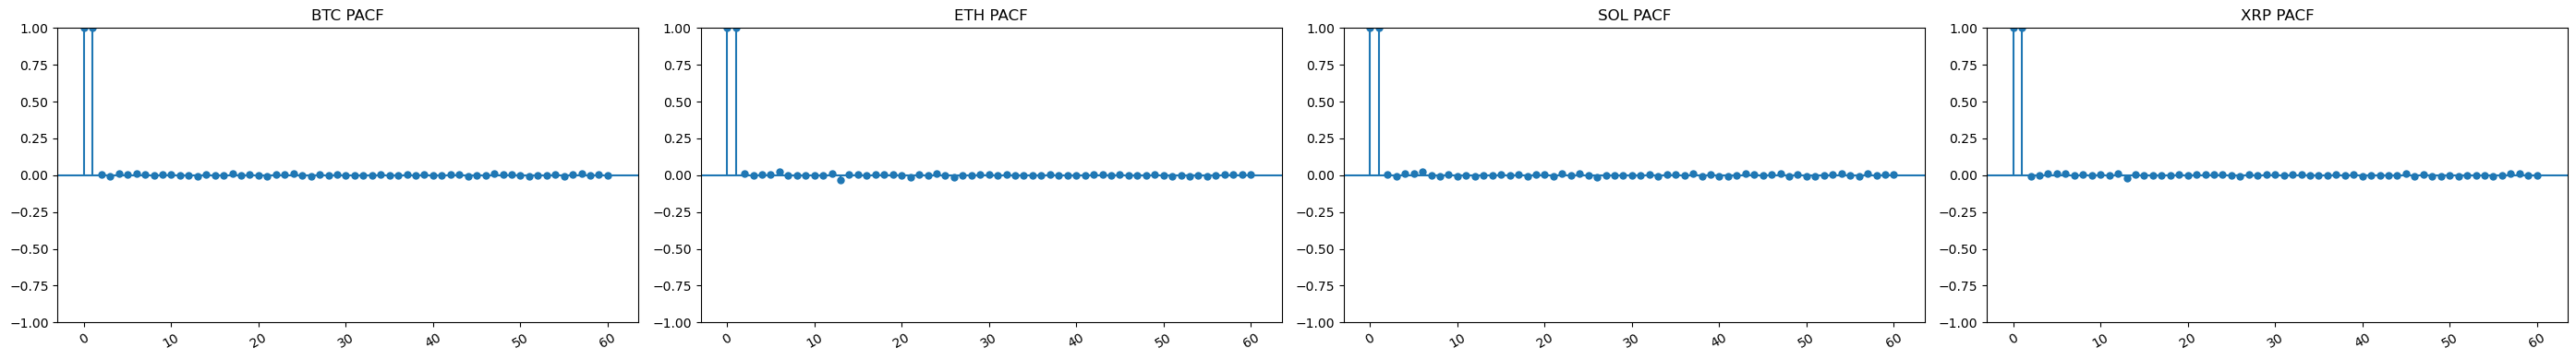

In [8]:
# Standard PACF Facet 
fig, axes = plt.subplots(1, len(crypto), figsize=(28, 4))
for ax, ticker in zip(axes, crypto):
    df_ticker = df[df['Coin'] == ticker]
    plot_pacf(df_ticker['Close'].dropna(), lags=60, ax=ax)
    ax.set_title(f'{ticker} PACF')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
plt.tight_layout()
plt.show()

In [9]:
# Stationarity Tests
for ticker in crypto:
    df_ticker = df[df['Coin'] == ticker]
    adf_result = adfuller(df_ticker['Close'].dropna())
    print(f'ADF Statistic for {ticker}: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}')
    if adf_result[1] < 0.05:
        print(f"{ticker} series is likely stationary.")
    else:
        print(f"{ticker} series is likely non-stationary.")

ADF Statistic for BTC: -1.0998, p-value: 0.7152
BTC series is likely non-stationary.
ADF Statistic for ETH: -0.5436, p-value: 0.8832
ETH series is likely non-stationary.
ADF Statistic for SOL: -0.7986, p-value: 0.8195
SOL series is likely non-stationary.
ADF Statistic for XRP: -1.7923, p-value: 0.3843
XRP series is likely non-stationary.


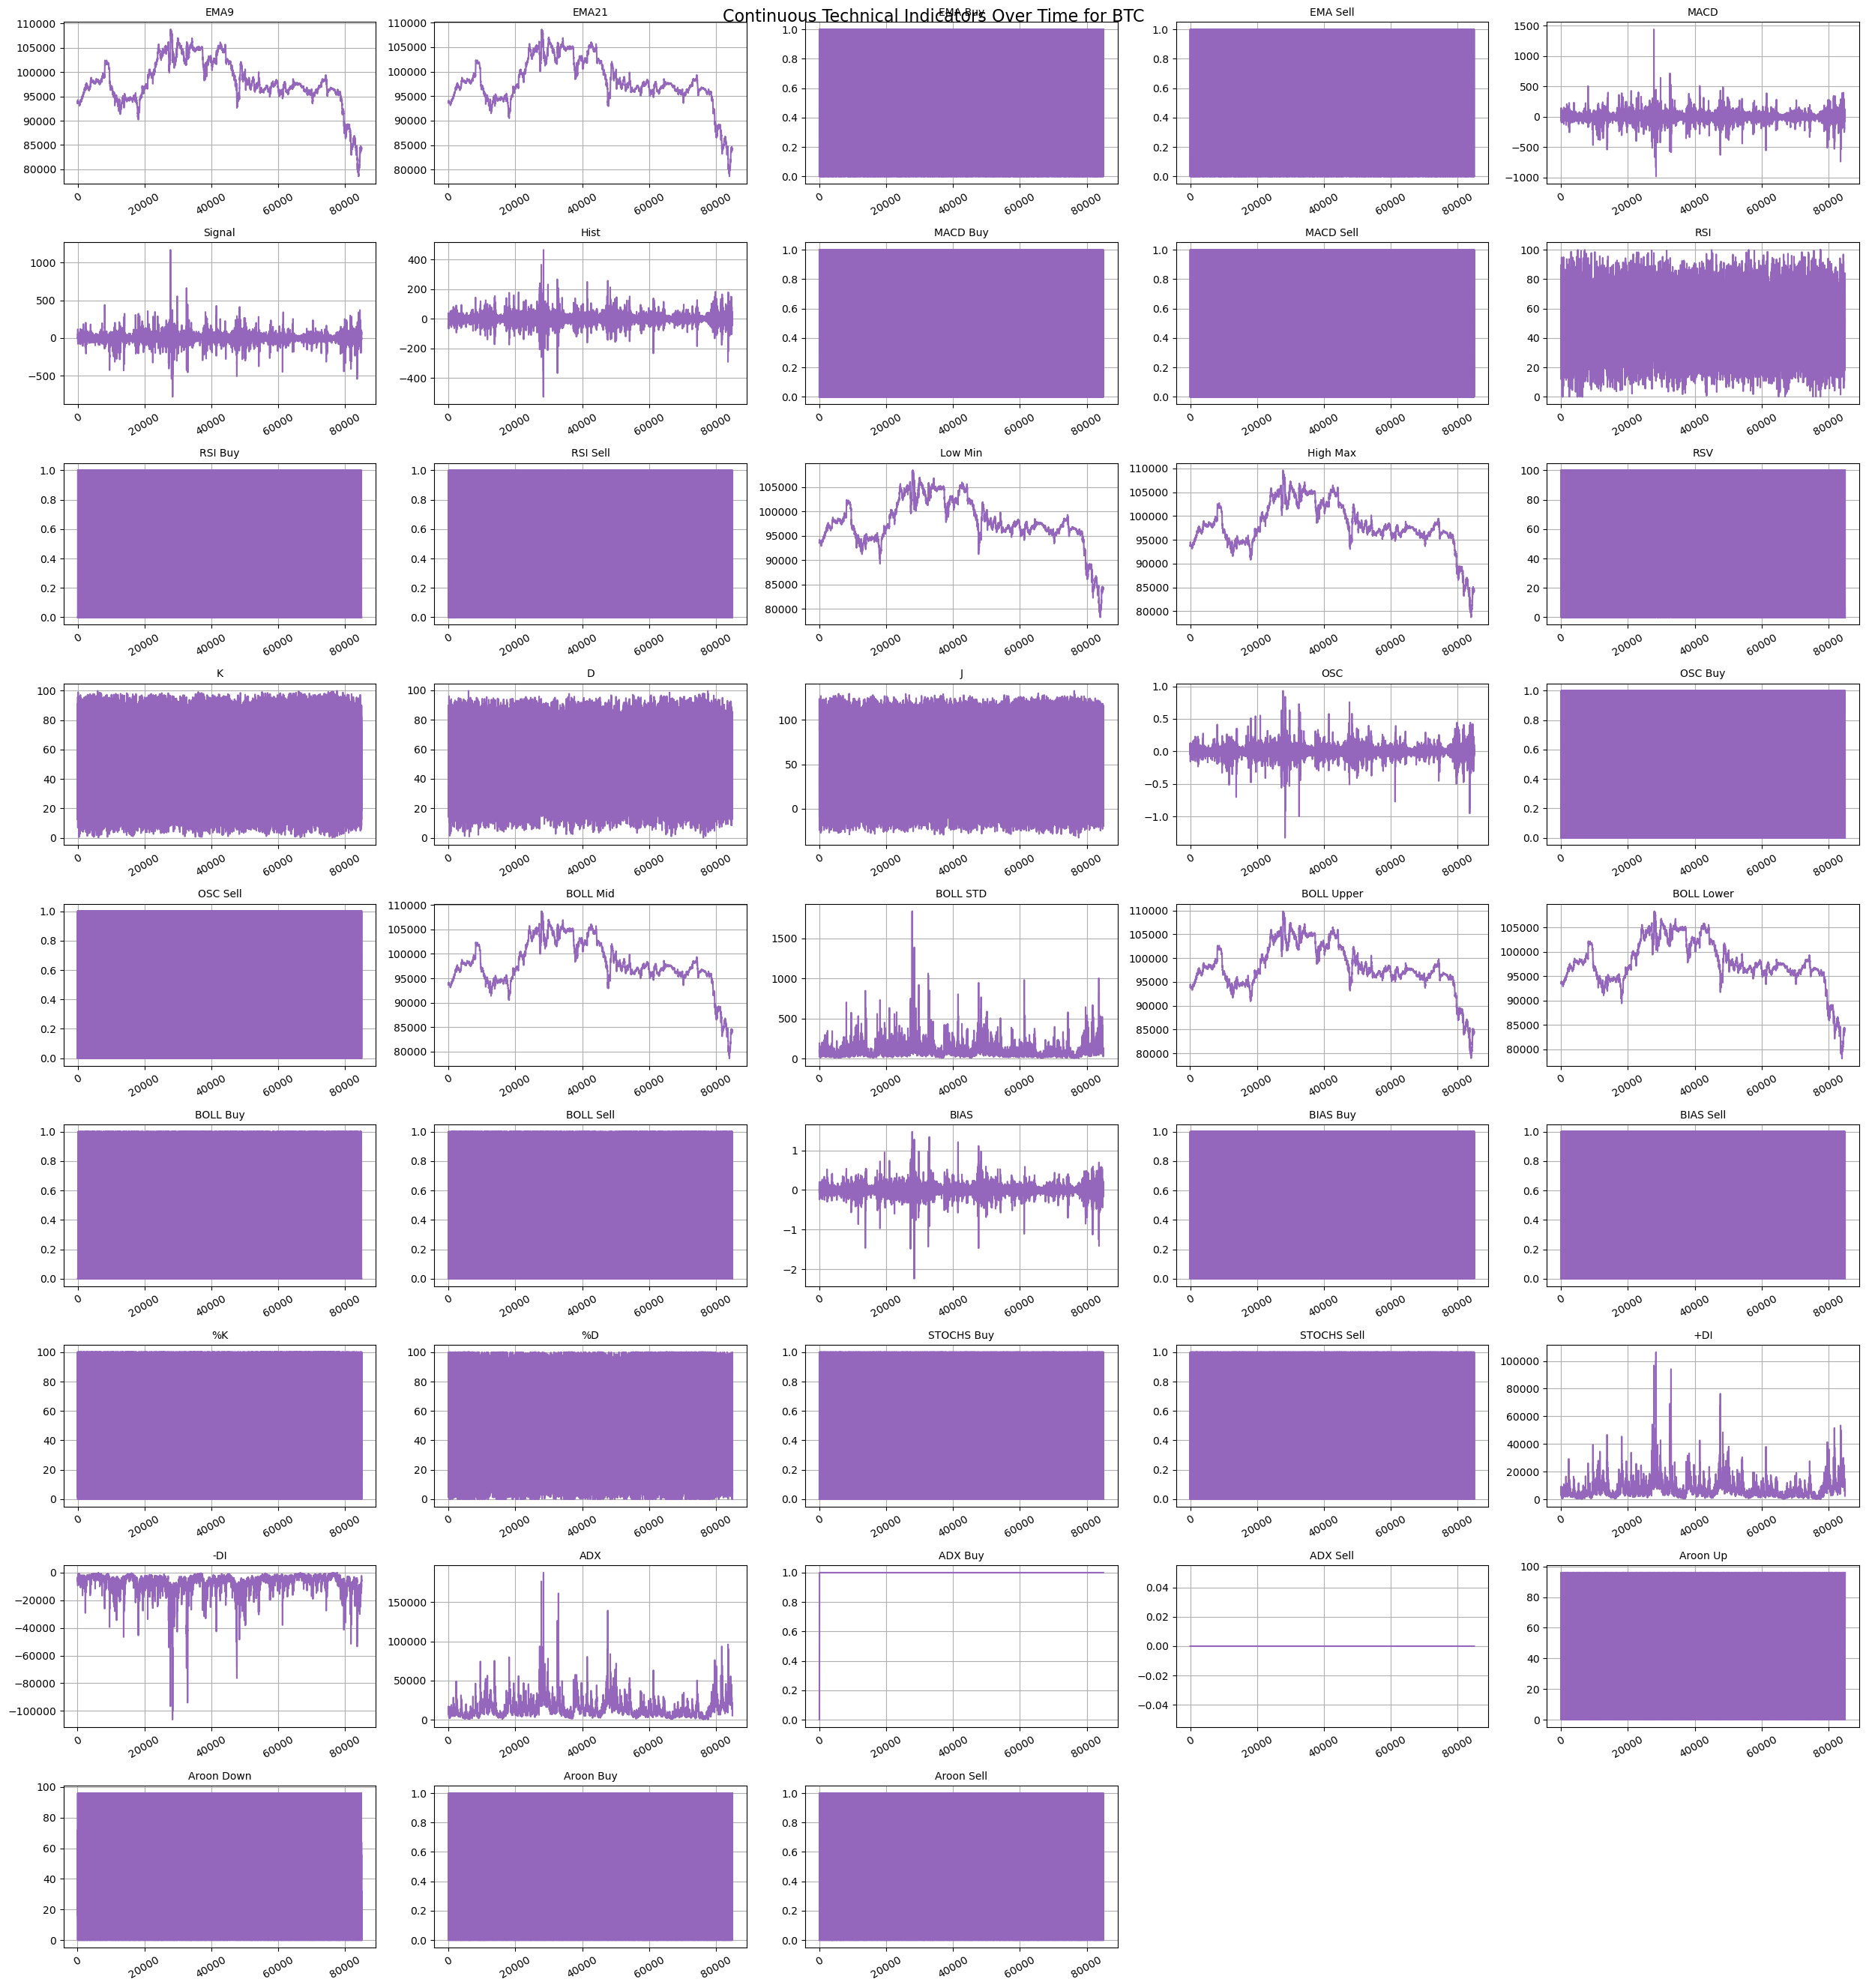

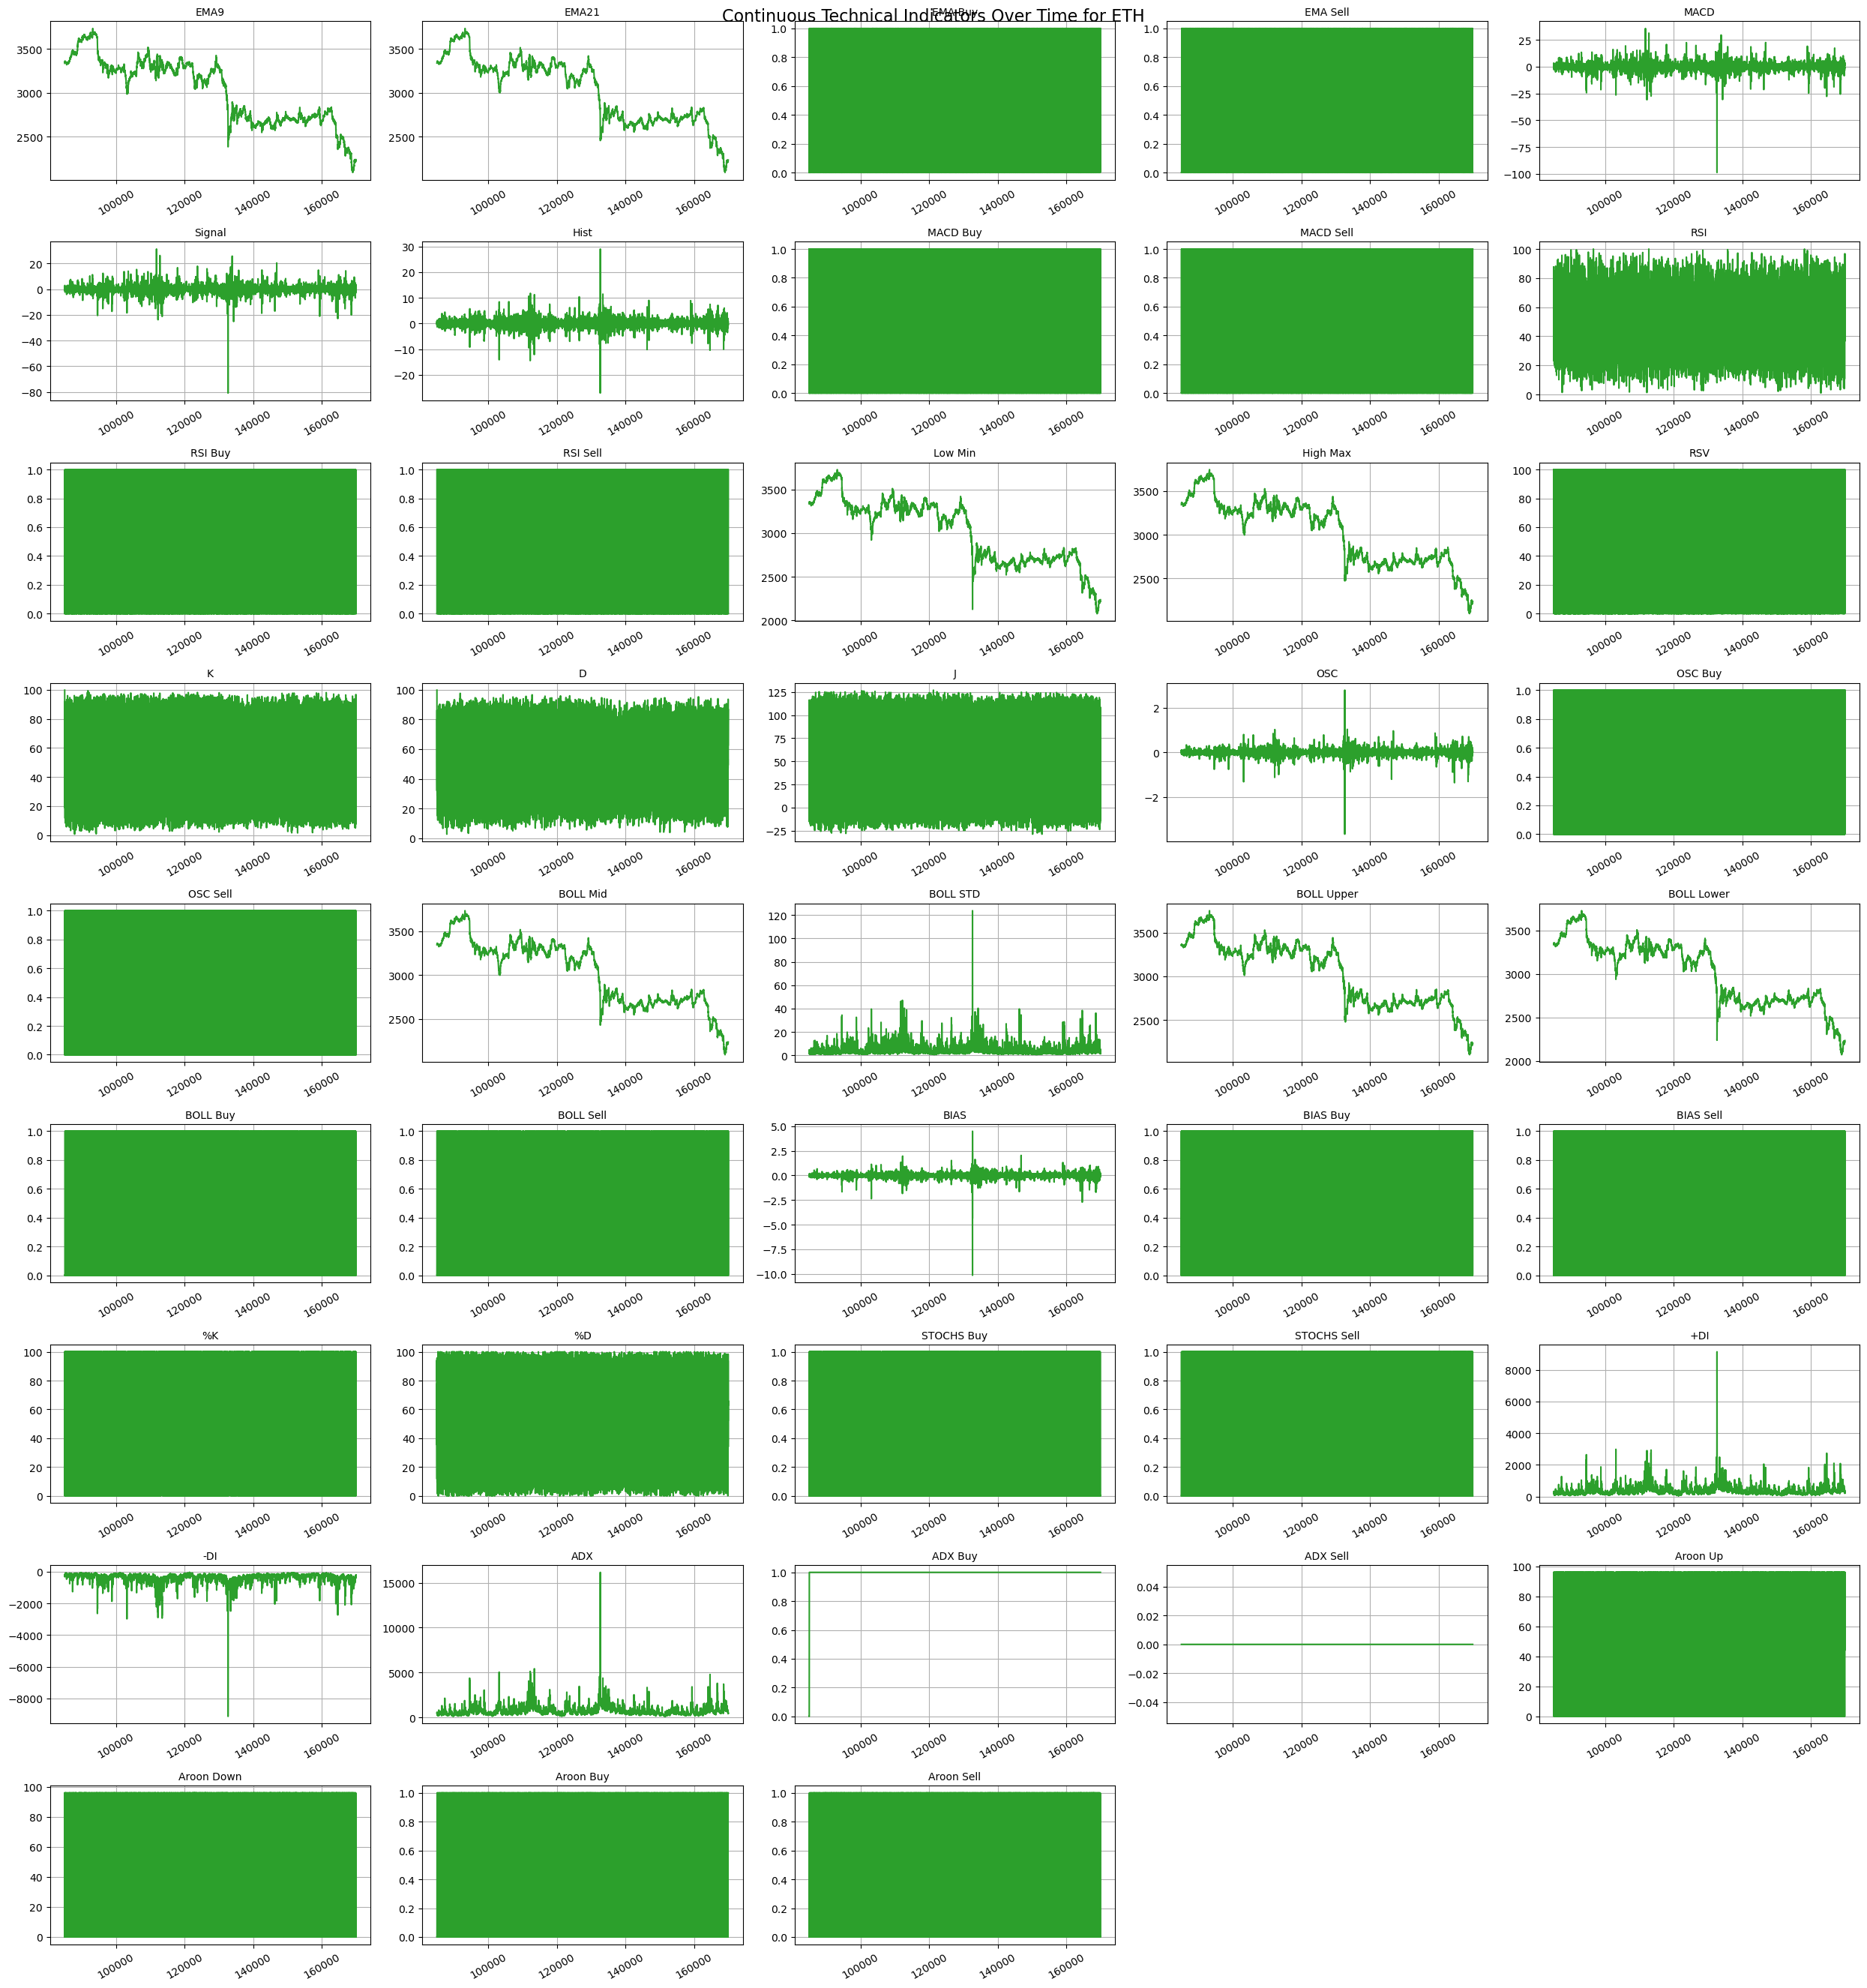

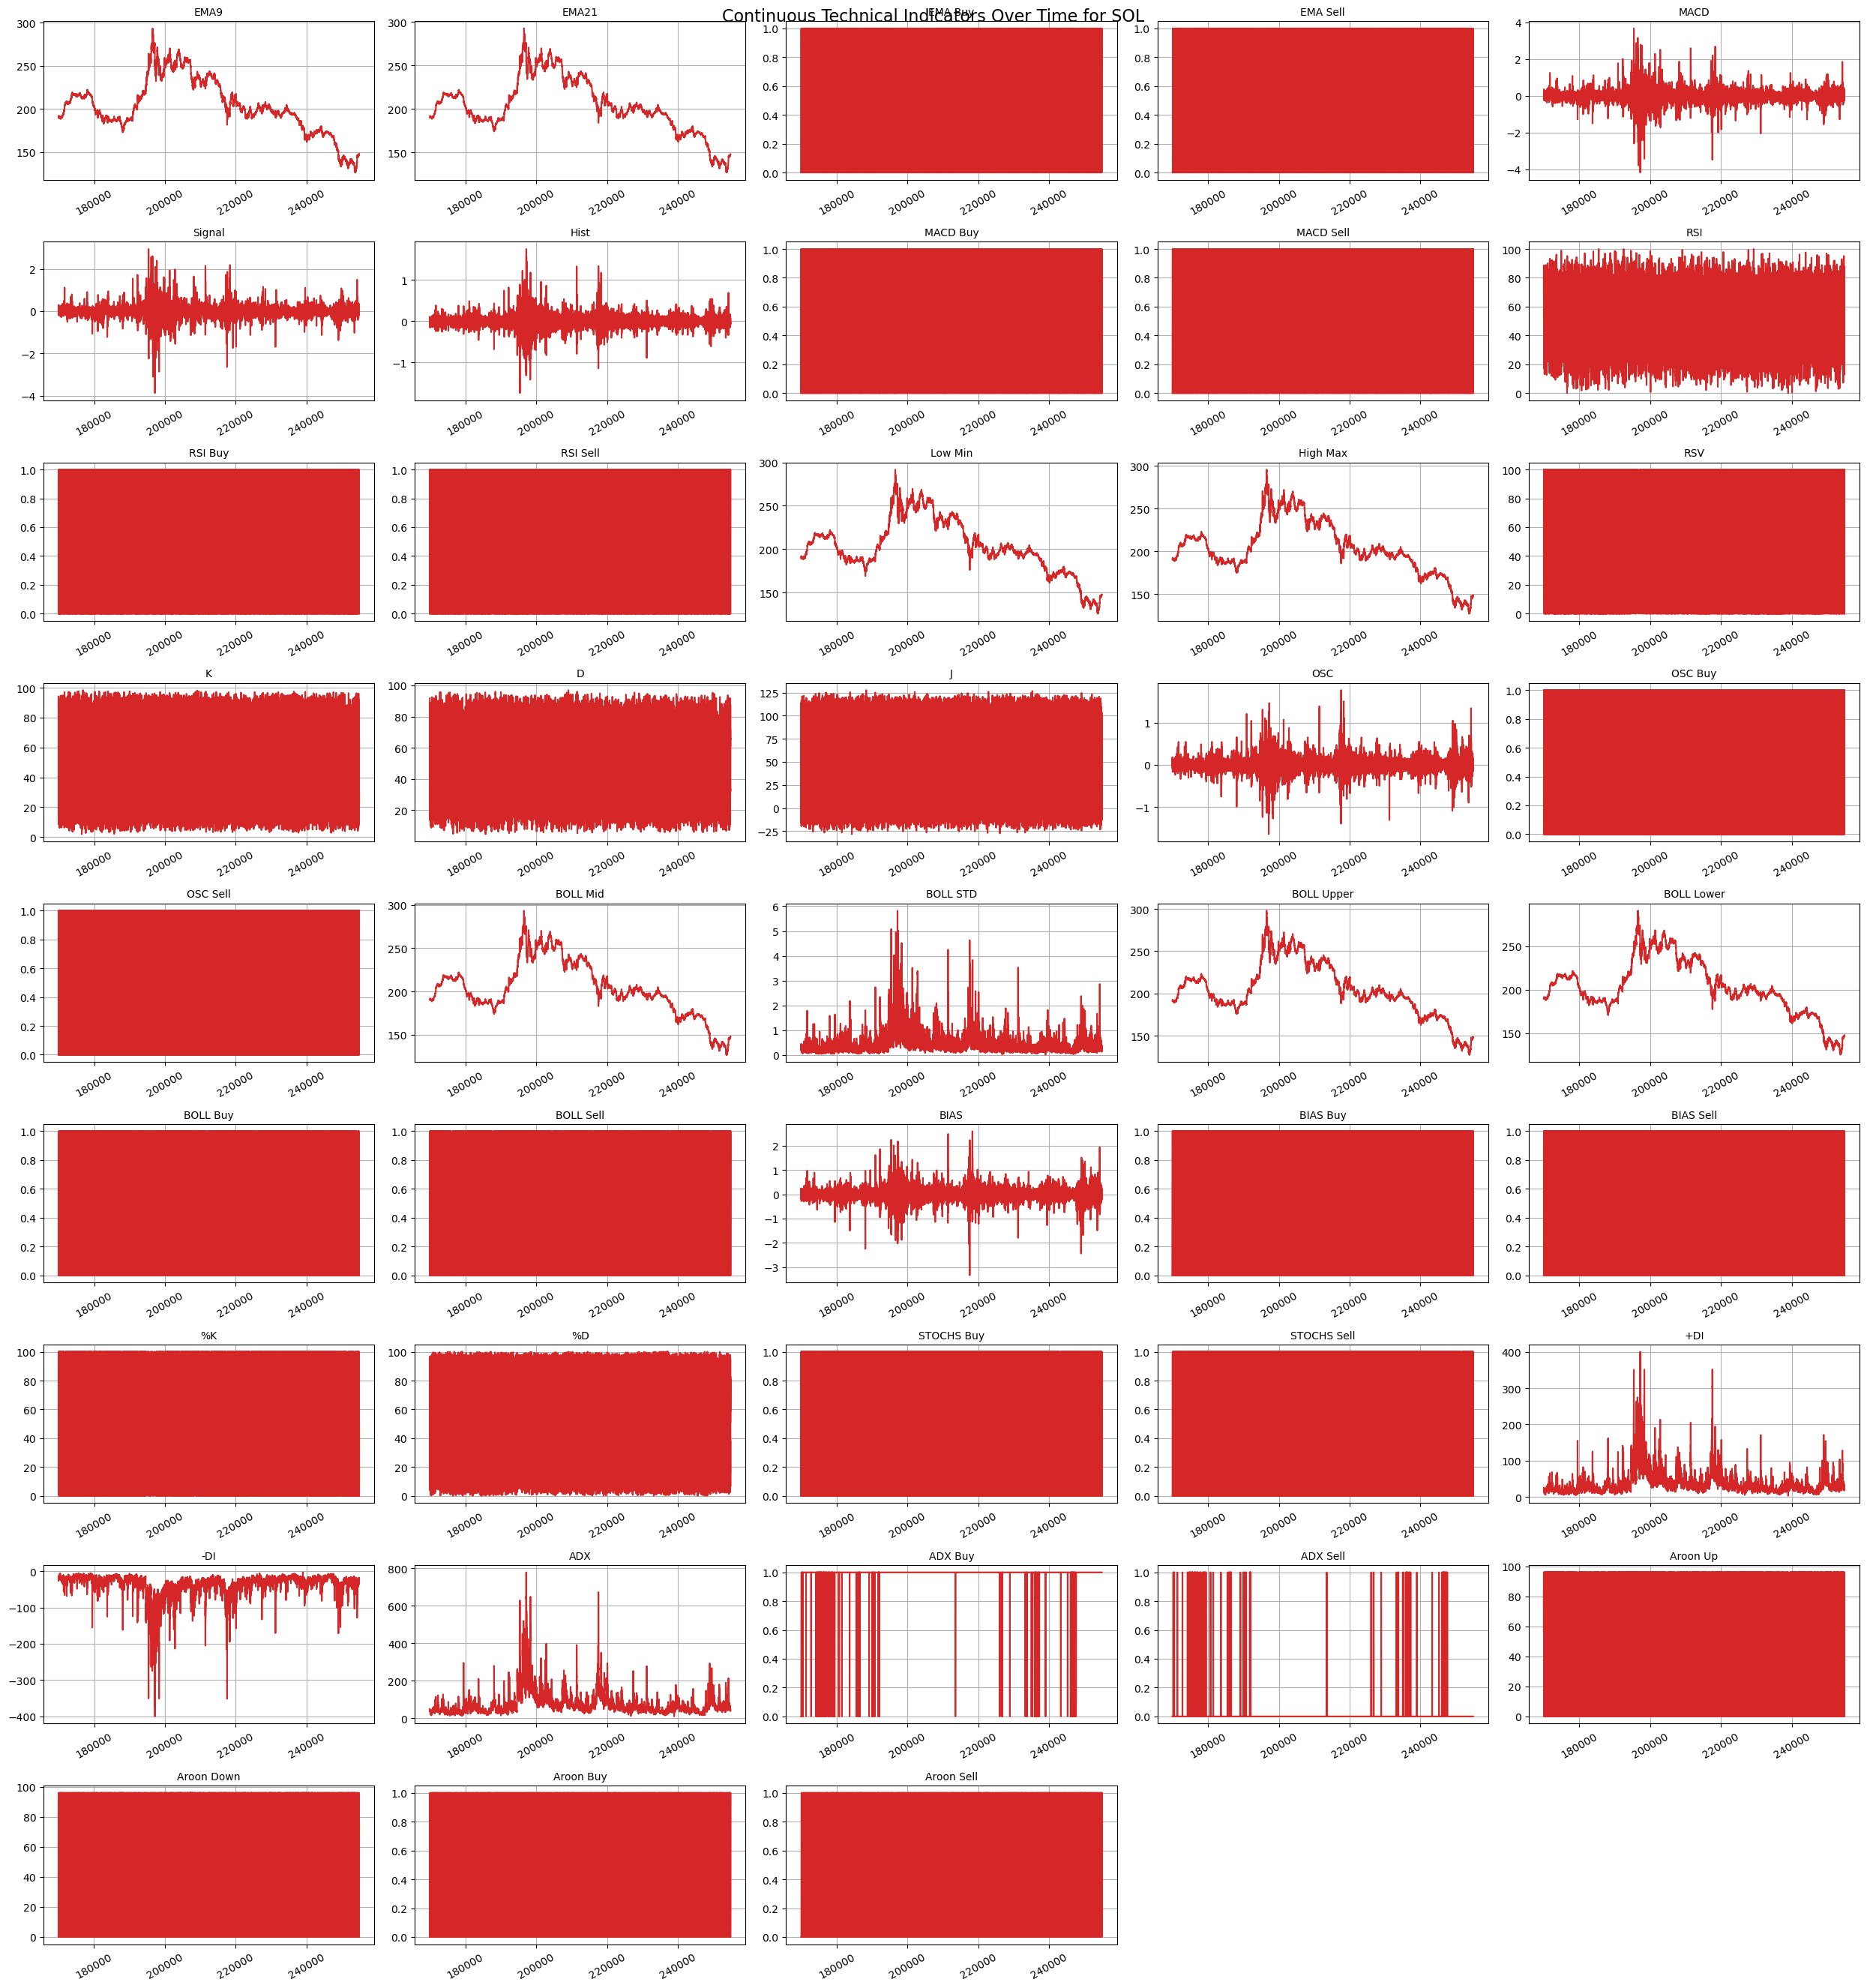

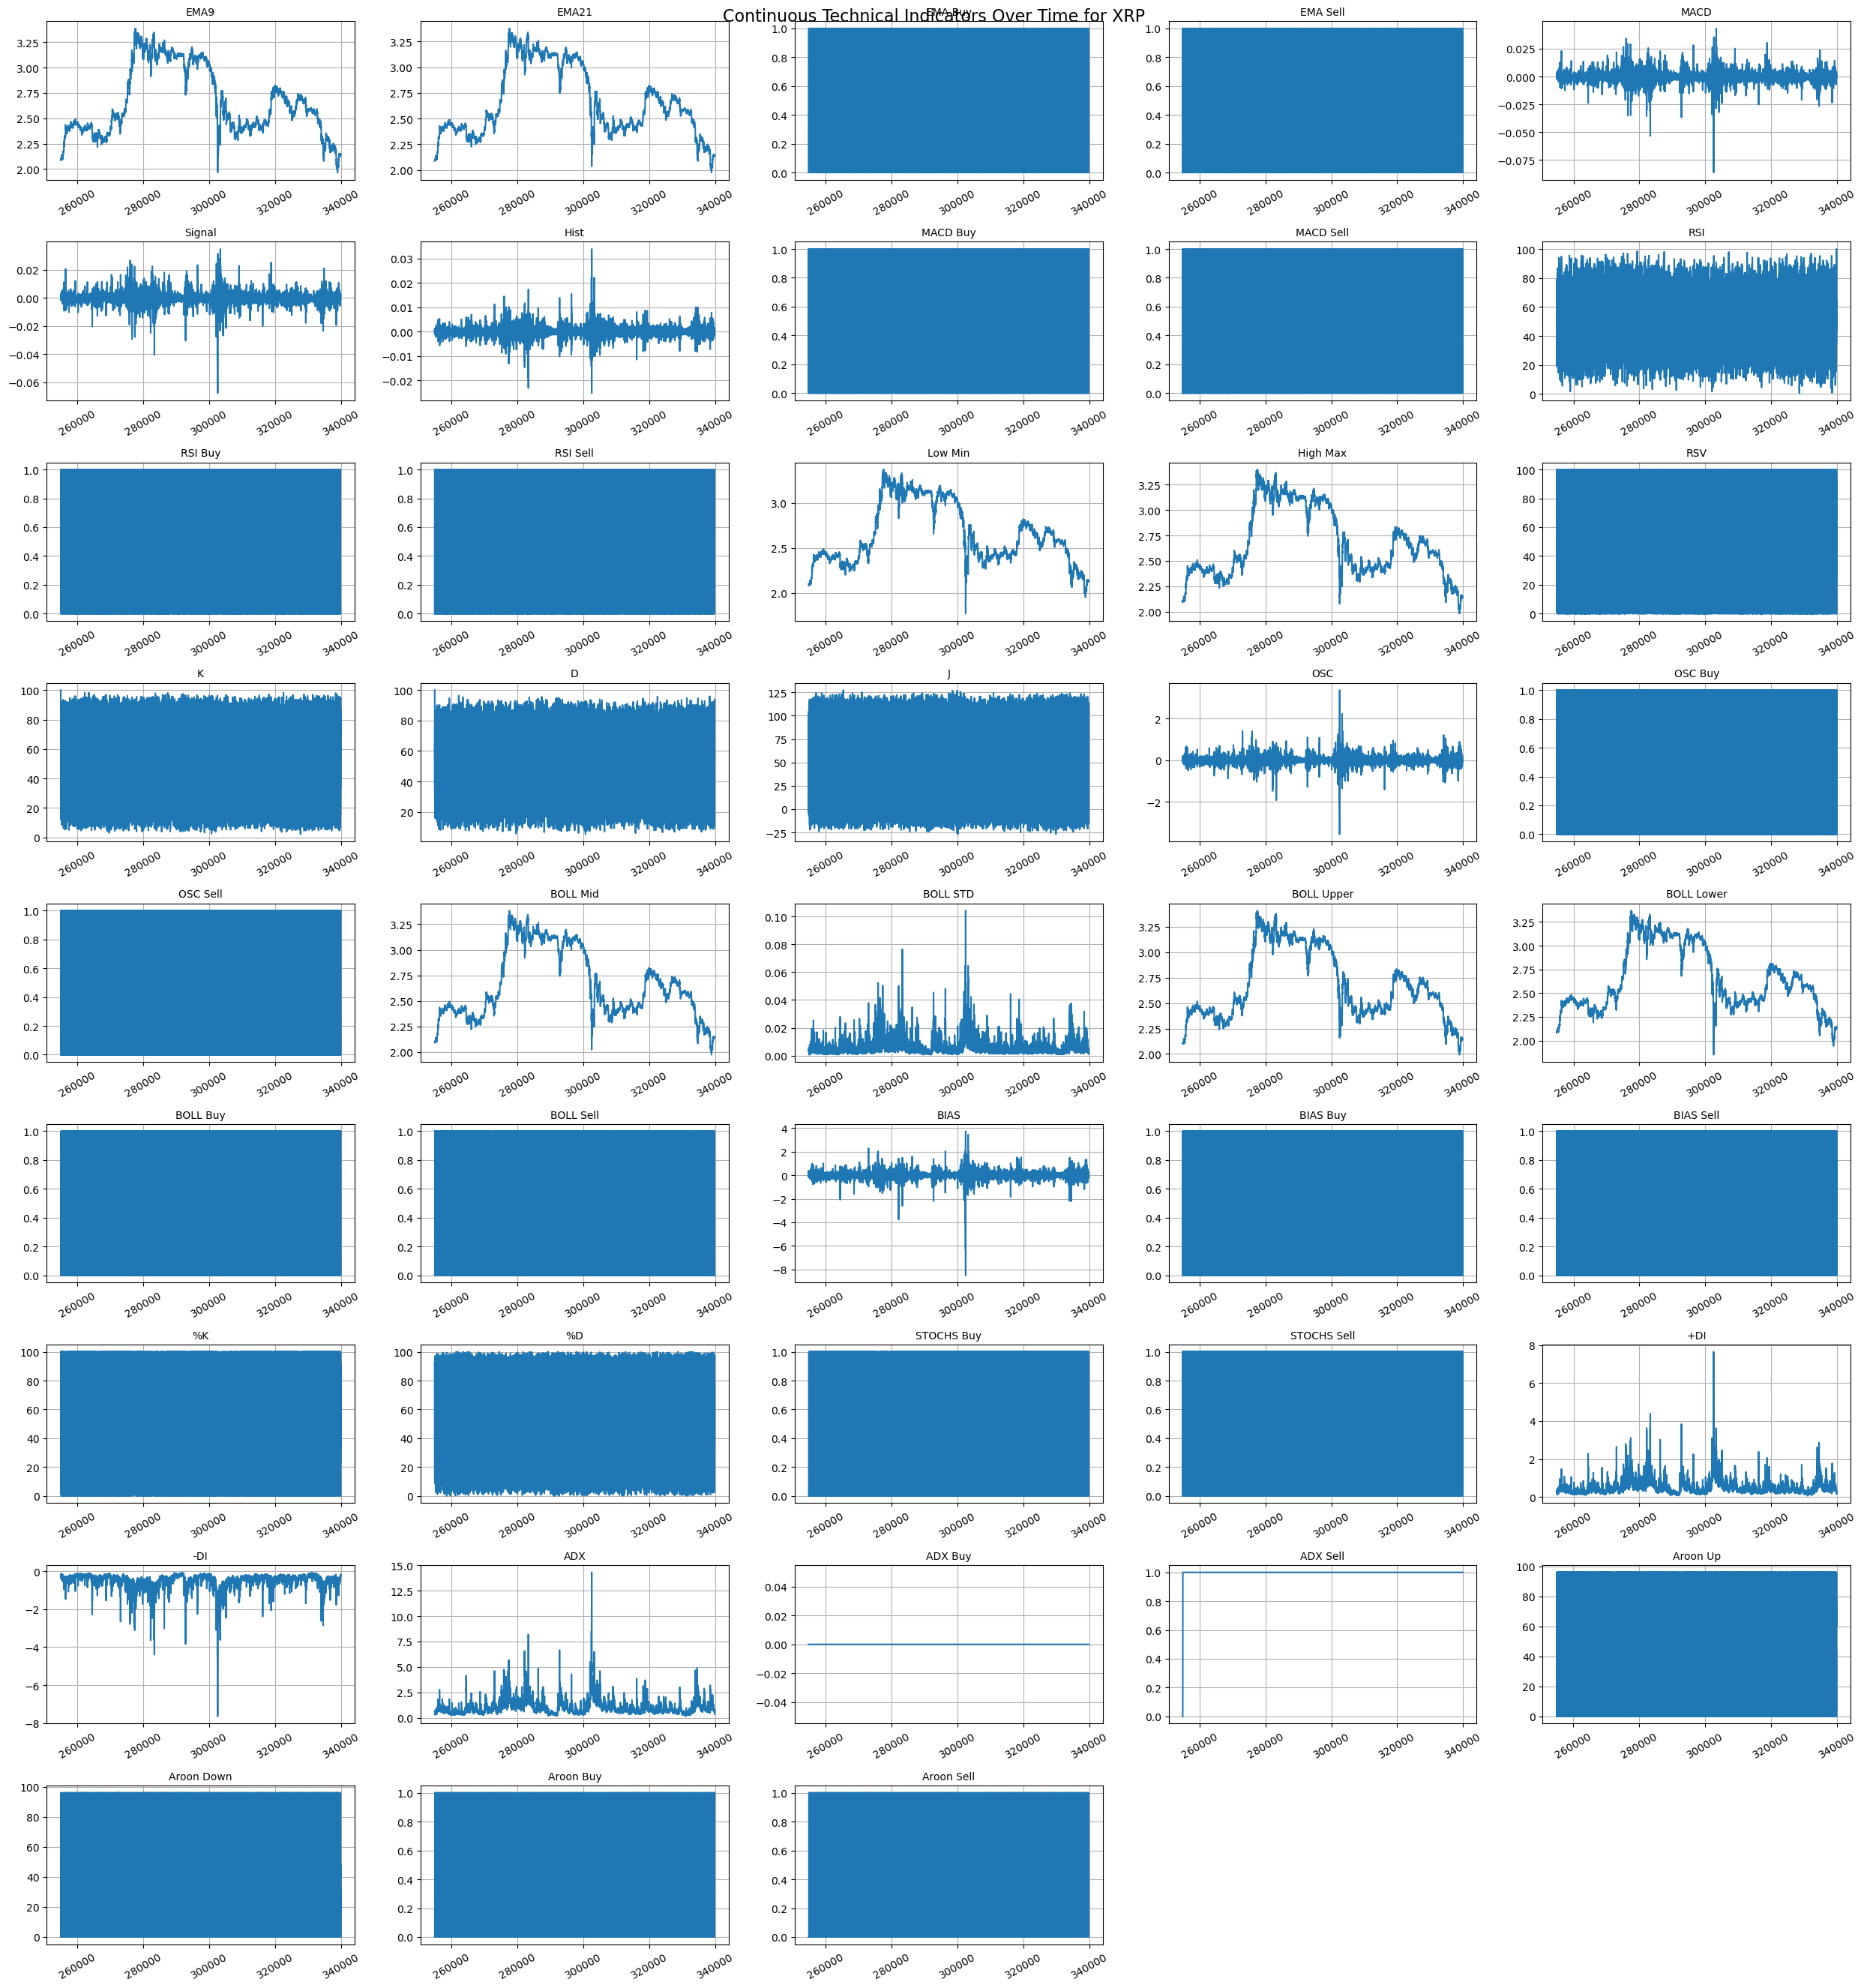

In [10]:
# Visualization of continuous technical indicators for each ticker
technical_columns = [col for col in df.columns if col not in ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Number of Trades', 'Coin']]
for token, color in zip(crypto, colors):
    df_token = df[df['Coin'] == token]
    n_cols = 5
    n_rows = (len(technical_columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, n_rows * 3))
    axes = axes.flatten()

    for i, col in enumerate(technical_columns):
        axes[i].plot(df_token.index, df_token[col], color=color)
        axes[i].set_title(col.replace('_', ' '), fontsize=10)
        axes[i].tick_params(axis='x', rotation=30)
        axes[i].grid(True)

    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Continuous Technical Indicators Over Time for {token}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [24]:
# Load both sentiment files
sent1 = pd.read_csv('../../curr_news/aggregated_daily_sentiment.csv')
sent2 = pd.read_csv('../../historic_news/aggregated_daily_sentiment.csv')

# Combine them in order: part 1 comes before part 2
sentiment = pd.concat([sent1, sent2], ignore_index=True)

# Rename and parse dates
sentiment.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
sentiment['Date'] = pd.to_datetime(sentiment['Date'])

# Reshape to long format: Date | Coin | Sentiment
sentiment = sentiment.melt(id_vars='Date', var_name='Coin', value_name='Sentiment')
sentiment['Date'] = sentiment['Date'].dt.normalize()
sentiment['Date'] = sentiment['Date'].dt.tz_localize(None)

# Prepare stock data date column
df['Date'] = df['Date'].dt.normalize()
df['Date'] = df['Date'].dt.tz_localize(None)

# Merge daily sentiment into intraday stock data
df = pd.merge(df, sentiment, how='left', on=['Date', 'Coin'])
df.drop(columns='Date', inplace=True)

# Fill any missing sentiment values with neutral (0)
df['Sentiment'] = df['Sentiment'].fillna(0)

In [25]:
df

,Date,Open,High,Low,Close,Volume,Number of Trades,Coin,EMA9,EMA21,...,+DI,-DI,ADX,ADX_Buy,ADX_Sell,Aroon_Up,Aroon_Down,Aroon_Buy,Aroon_Sell,Sentiment
0,2025-01-01,93576.0000,93610.9300,93537.5000,93610.9300,8.21827,2631,BTC,93610.930000,93610.930000,...,NaN,NaN,NaN,False,False,NaN,NaN,False,False,0.0
1,2025-01-01,93610.9300,93652.0000,93606.2000,93652.0000,12.14029,1273,BTC,93619.144000,93614.663636,...,NaN,NaN,NaN,False,False,NaN,NaN,False,False,0.0
2,2025-01-01,93652.0000,93702.1500,93635.9800,93702.1500,11.60597,1095,BTC,93635.745200,93622.616942,...,NaN,NaN,NaN,False,False,NaN,NaN,False,False,0.0
3,2025-01-01,93702.1400,93702.1500,93654.4800,93677.9800,8.72958,1461,BTC,93644.192160,93627.649947,...,NaN,NaN,NaN,False,False,NaN,NaN,False,False,0.0
4,2025-01-01,93677.9800,93677.9900,93659.9200,93661.2000,5.24749,988,BTC,93647.593728,93630.699952,...,NaN,NaN,NaN,False,False,NaN,NaN,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339839,2025-02-28,2.1471,2.1472,2.1461,2.1464,38632.00000,222,XRP,2.146134,2.144897,...,0.238571,-0.238571,0.426122,False,True,92.0,0.0,True,False,0.0
339840,2025-02-28,2.1464,2.1466,2.1450,2.1464,47479.00000,356,XRP,2.146187,2.145033,...,0.242143,-0.242143,0.436735,False,True,88.0,0.0,True,False,0.0
339841,2025-02-28,2.1464,2.1479,2.1462,2.1476,79483.00000,288,XRP,2.146470,2.145267,...,0.242143,-0.242143,0.448776,False,True,84.0,48.0,True,False,0.0
339842,2025-02-28,2.1475,2.1478,2.1451,2.1453,30647.00000,302,XRP,2.146236,2.145270,...,0.230000,-0.230000,0.456837,False,True,80.0,44.0,True,False,0.0


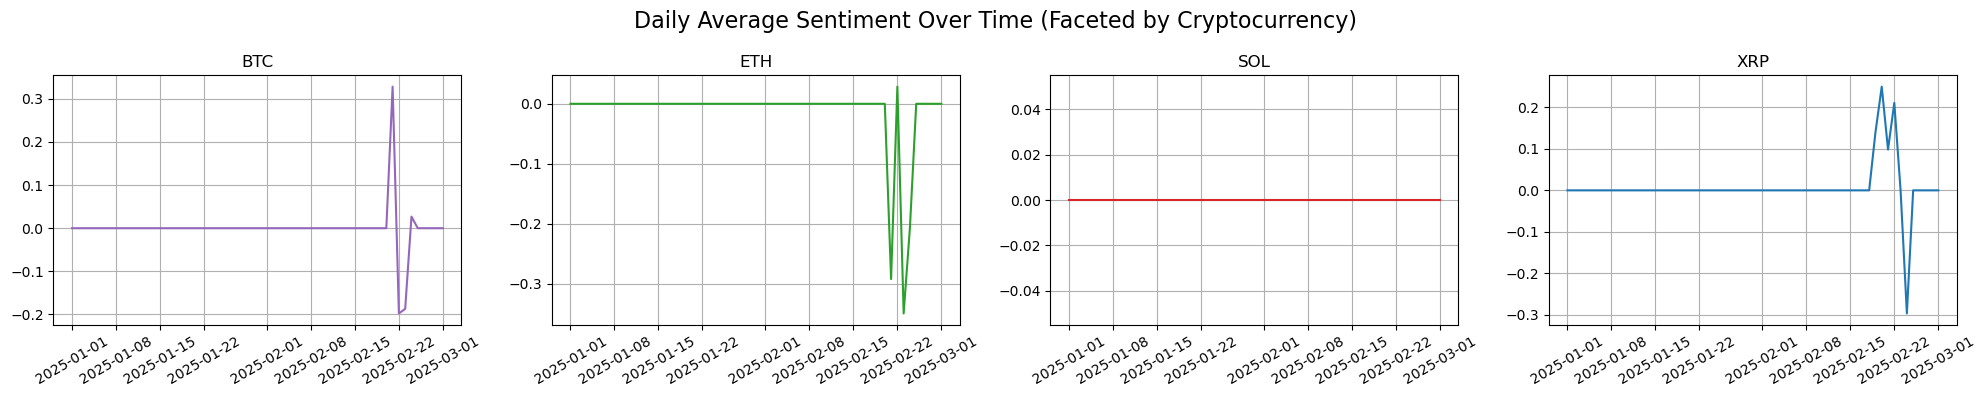

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for ax, coin, color in zip(axes, crypto, colors):
    df_stock = df[df['Coin'] == coin]
    sentiment_daily = df_stock.resample('1D', on='Date')['Sentiment'].mean()

    ax.plot(sentiment_daily.index, sentiment_daily.values, color=color, label='Sentiment')
    ax.set_title(coin)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=30)

plt.suptitle('Daily Average Sentiment Over Time (Faceted by Cryptocurrency)', fontsize=16)
plt.tight_layout()
plt.show()